In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Load dataset
file_path = "C:/Users/91749/Downloads/Goa University Dissertation (1).xlsx"
xls = pd.ExcelFile(file_path)
df = xls.parse("Onsite Form Responses ")

In [6]:
# Convert Date of Collection to datetime if available

    
# Extract useful components
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Weekday'] = df['Timestamp'].dt.weekday  # 0 = Monday, 6 = Sunday
df['Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
df['Is Feast Day'] = df['Timestamp'].isin(['2024-12-03']).astype(int)  # Add your feast dates


# Clean column names
df.columns = df.columns.str.strip()
print(df.columns)
df['State/Country'] = df['State/Country'].apply(lambda x: str(x).strip().lower())
df['Gender:'] = df['Gender:'].apply(lambda x: str(x).strip().lower())
df['Are you camping at the Basilica?'] = df['Are you camping at the Basilica?'].apply(lambda x: str(x).strip().lower())
df['Age groups'] = df['Age groups'].apply(lambda x: str(x).strip().lower())
df['Type of visitors'] = df['Type of visitors'].apply(lambda x: str(x).strip().lower())
df['walking pilgrim'] = df['walking pilgrim'].apply(lambda x: str(x).strip().lower())

# Split 'Event Attending' column into individual events
#df['Event Attending'] = df['Event Attending'].str.split(',')

#event_types = ["Veneration of Relics", "Mass", "Fair / Cultural Event / Sightseeing"]

#for event in event_types:
    #df[event] = df['Event Attending'].apply(lambda x: 1 if event in str(x) else 0)




Index(['Timestamp', 'Your Age', 'Gender:',
       'State of Residence in India/ Country', 'Event Attending',
       'How many years (approx) have you been visiting the Basilica?',
       'Are you camping at the Basilica?',
       'I agree to have my information used only for research purposes.',
       'walking pilgrim', 'State/Country', 'Region', 'Age groups',
       'No of times visited', 'Type of visitors', 'Country', 'Column 1', 'Day',
       'Month', 'Weekday', 'Weekend', 'Is Feast Day'],
      dtype='object')


In [7]:

# Split the 'Event Attending' column by commas and strip extra spaces
#df['Event Attending'] = df['Event Attending'].str.split(',')
#df['Event Attending'] = df['Event Attending'].str.strip()
df['Event Attending'] = df['Event Attending'].apply(lambda x: [i.strip() for i in x.split(',')] if pd.notna(x) else [])
print(df['Event Attending'].head(5)) 


# Create new columns for each event
df['Veneration of Relics'] = df['Event Attending'].apply(lambda x: 1 if 'Veneration of Relics' in x else 0)
df['Mass'] = df['Event Attending'].apply(lambda x: 1 if 'Mass' in x else 0)
df['Fair/Cultural Event/Sightseeing'] = df['Event Attending'].apply(lambda x: 1 if 'Fair / Cultural Event / Sightseeing' in x else 0)
df['Walking pilgrimage'] = df['Event Attending'].apply(lambda x: 1 if 'Walking pilgrimage' in x else 0)

# Checking the updated DataFrame
print(df[['Veneration of Relics', 'Mass', 'Fair/Cultural Event/Sightseeing','Walking pilgrimage']].head(30))

# Step 3: Explode the list into rows
#df_exploded = df.explode('Event Attending')
#df_exploded = df_exploded[df_exploded['Event Attending'] != 'Walking pilgrimage']

0                         [Veneration of Relics, Mass]
1                [Fair / Cultural Event / Sightseeing]
2    [Veneration of Relics, Mass, Fair / Cultural E...
3    [Veneration of Relics, Mass, Fair / Cultural E...
4    [Veneration of Relics, Mass, Fair / Cultural E...
Name: Event Attending, dtype: object
    Veneration of Relics  Mass  Fair/Cultural Event/Sightseeing  \
0                      1     1                                0   
1                      0     0                                1   
2                      1     1                                1   
3                      1     1                                1   
4                      1     1                                1   
5                      1     1                                0   
6                      1     1                                1   
7                      1     1                                1   
8                      1     1                                1   
9                 

In [8]:
# Standardizing Gender values
df["Gender:"] = df["Gender:"].replace({"male": "Male"})
print(df['Gender:'].head(5)) 

0    female
1    female
2    female
3      Male
4      Male
Name: Gender:, dtype: object


In [9]:

# Encode categorical variables
le_gender = LabelEncoder()
le_state = LabelEncoder()
le_stay = LabelEncoder()
le_age = LabelEncoder()
le_visitcount=LabelEncoder()
df['Gender:'] = le_gender.fit_transform(df['Gender:'])
df['State/Country'] = le_state.fit_transform(df['State/Country'])
#df["Region"] = le_state.fit_transform(df["Region"])

df["Are you camping at the Basilica?"] = le_stay.fit_transform(df["Are you camping at the Basilica?"])
df["Age groups"] = le_age.fit_transform(df["Age groups"])
df["Type of visitors"] = le_visitcount.fit_transform(df["Type of visitors"])
le_wp = LabelEncoder()
le_event = LabelEncoder()
df['walking pilgrim'] = le_wp.fit_transform(df['walking pilgrim'])
print(df.head(5))


   Timestamp  Your Age  Gender: State of Residence in India/ Country  \
0 2024-11-24        68        1                                  Goa   
1 2024-11-24        17        1                           Chandigarh   
2 2024-11-24        40        1                           Tamil Nadu   
3 2024-11-24        42        0                           Tamil Nadu   
4 2024-11-24        75        0                          Tamil Nadu    

                                     Event Attending  \
0                       [Veneration of Relics, Mass]   
1              [Fair / Cultural Event / Sightseeing]   
2  [Veneration of Relics, Mass, Fair / Cultural E...   
3  [Veneration of Relics, Mass, Fair / Cultural E...   
4  [Veneration of Relics, Mass, Fair / Cultural E...   

  How many years (approx) have you been visiting the Basilica?  \
0                                  Its my first time             
1                                  Its my first time             
2                               

In [38]:

'''
# Encode target
#le_main_event = LabelEncoder()
#df['Main Event Encoded'] = le_main_event.fit_transform(df['Event Attending'])

# Features and encoded target
X = df[['Age groups', 'Gender:', 'Region', 'Type of visitors', 'Are you camping at the Basilica?']]
y = df['']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate using encoded labels
print("\n--- Random Forest (One Event per Row) ---")
print(classification_report(y_test, y_pred, target_names=le_main_event.classes_))
print("Accuracy Score:", accuracy_score(y_test, y_pred))'''


'\n# Encode target\n#le_main_event = LabelEncoder()\n#df[\'Main Event Encoded\'] = le_main_event.fit_transform(df[\'Event Attending\'])\n\n# Features and encoded target\nX = df[[\'Age groups\', \'Gender:\', \'Region\', \'Type of visitors\', \'Are you camping at the Basilica?\']]\ny = df[\'\']\n\n# Train-test split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\n# Train model\nrf = RandomForestClassifier(random_state=42, class_weight=\'balanced\')\nrf.fit(X_train, y_train)\n\n# Predict\ny_pred = rf.predict(X_test)\n\n# Evaluate using encoded labels\nprint("\n--- Random Forest (One Event per Row) ---")\nprint(classification_report(y_test, y_pred, target_names=le_main_event.classes_))\nprint("Accuracy Score:", accuracy_score(y_test, y_pred))'

In [10]:
# Replace "It's my first time" with 1 in Visit_Count column
df["No of times visited"] = df["No of times visited"].replace("Its my first time", 1)

In [11]:
# Define features and labels
X = df[['Age groups', 'Gender:', 'State/Country', 'Type of visitors', 'Are you camping at the Basilica?', 'Weekend', 'Is Feast Day']]
y = df[['Fair/Cultural Event/Sightseeing','Veneration of Relics', 'Mass']]

C:\Users\91749\AppData\Local\Temp\ipykernel_10160\267207355.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = (df).corr()


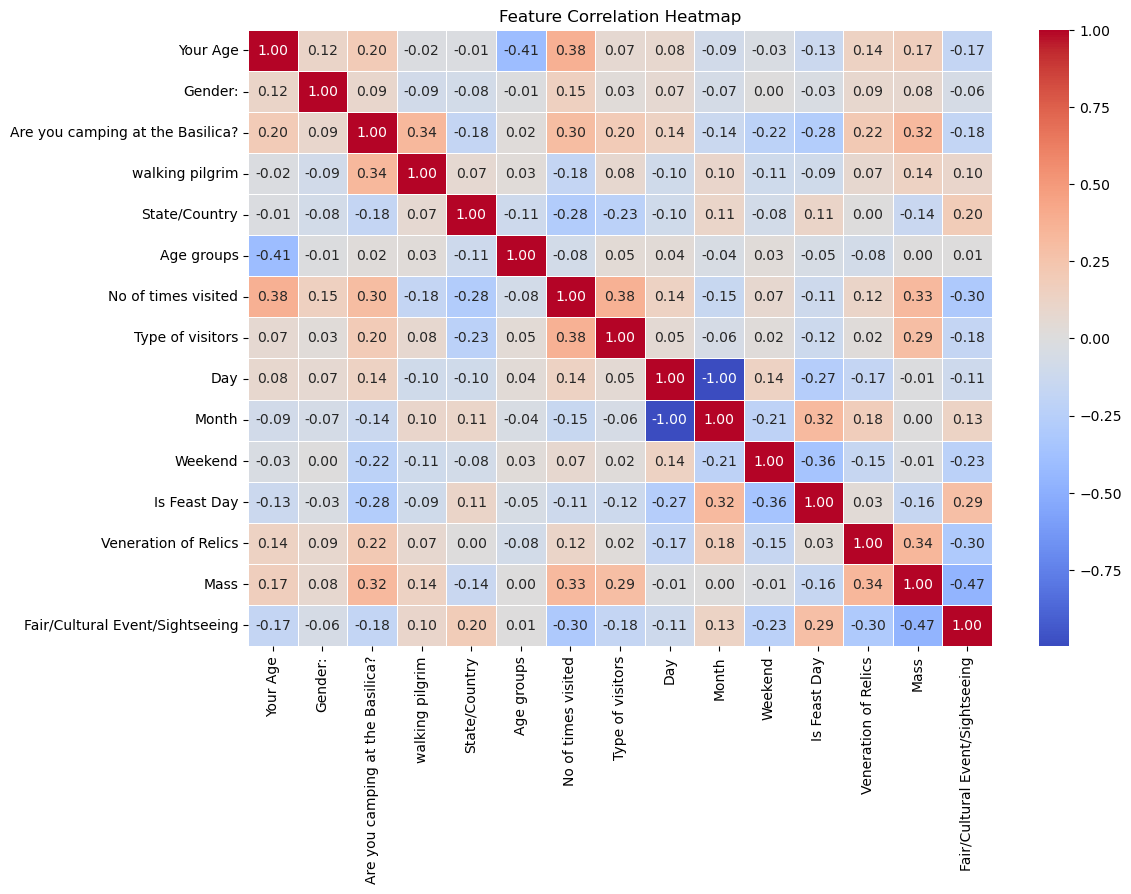

In [12]:
##y = df[['Fair/Cultural Event/Sightseeing']]
#y = df[['Event Attending']]
#  Correlation Heatmap
df = df.drop(columns=['Column 1', 'Walking pilgrimage','Weekday'])
plt.figure(figsize=(12, 8))
corr_matrix = (df).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [13]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:

'''from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("\n--- Random Forest Classifier (Single Output) ---")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))'''

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import classification_report, accuracy_score\n\nrf_model = RandomForestClassifier(random_state=42)\nrf_model.fit(X_train, y_train)\ny_pred = rf_model.predict(X_test)\n\nprint("\n--- Random Forest Classifier (Single Output) ---")\nprint(classification_report(y_test, y_pred))\nprint("Accuracy Score:", accuracy_score(y_test, y_pred))'

In [14]:
from sklearn.metrics import hamming_loss, jaccard_score



### Random Forest Classifier ###
print("\n--- Random Forest Classifier ---")
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=y.columns))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Hamming Loss:", hamming_loss(y_test, y_pred_rf))
print("Jaccard Score (macro):", jaccard_score(y_test, y_pred_rf, average='macro'))


--- Random Forest Classifier ---
                                 precision    recall  f1-score   support

Fair/Cultural Event/Sightseeing       0.75      0.76      0.75       369
           Veneration of Relics       0.79      0.78      0.78       472
                           Mass       0.72      0.74      0.73       316

                      micro avg       0.76      0.76      0.76      1157
                      macro avg       0.75      0.76      0.76      1157
                   weighted avg       0.76      0.76      0.76      1157
                    samples avg       0.73      0.74      0.71      1157

Accuracy Score: 0.4723076923076923
Hamming Loss: 0.28717948717948716
Jaccard Score (macro): 0.6080117415126778


c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
importances = rf_model.estimators_[0].feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print('Feature Importance\n',feature_importance)

Feature Importance
 State/Country                       0.440226
Age groups                          0.201866
Type of visitors                    0.129544
Is Feast Day                        0.079949
Weekend                             0.059538
Are you camping at the Basilica?    0.044551
Gender:                             0.044325
dtype: float64


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import hamming_loss, jaccard_score



### Random Forest Classifier ###
print("\n--- Random Forest Classifier ---")
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=y.columns))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Hamming Loss:", hamming_loss(y_test, y_pred_rf))
print("Jaccard Score (macro):", jaccard_score(y_test, y_pred_rf, average='macro'))

### Decision tree Classifier ###
print("\n--- Decision tree Classifier ---")
log_model = MultiOutputClassifier(OneVsRestClassifier(DecisionTreeClassifier(random_state=42)))
log_model.fit(X_train, y_train)
y_pred_log1 = log_model.predict(X_test)
print(classification_report(y_test, y_pred_log1, target_names=y.columns))
print("Accuracy Score:", accuracy_score(y_test, y_pred_log1))
print("Hamming Loss:", hamming_loss(y_test, y_pred_log1))
print("Jaccard Score (macro):", jaccard_score(y_test, y_pred_log1, average='macro'))

### Logistic Regression Classifier ###
print("\n--- Logistic Regression Classifier ---")
log_model = MultiOutputClassifier(OneVsRestClassifier(LogisticRegression(max_iter=1000)))
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print(classification_report(y_test, y_pred_log, target_names=y.columns))
print("Accuracy Score:", accuracy_score(y_test, y_pred_log))
print("Hamming Loss:", hamming_loss(y_test, y_pred_rf))
print("Jaccard Score (macro):", jaccard_score(y_test, y_pred_rf, average='macro'))

### Support Vector Machine Classifier ###
print("\n--- Support Vector Machine Classifier ---")
svm_model = MultiOutputClassifier(OneVsRestClassifier(SVC()))
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm, target_names=y.columns))
print("Accuracy Score:", accuracy_score(y_test, y_pred_svm))
print("Hamming Loss:", hamming_loss(y_test, y_pred_svm))
print("Jaccard Score (macro):", jaccard_score(y_test, y_pred_svm, average='macro'))

### k-Nearest Neighbors Classifier ###
print("\n--- k-Nearest Neighbors Classifier ---")
knn_model = MultiOutputClassifier(KNeighborsClassifier())
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print(classification_report(y_test, y_pred_knn, target_names=y.columns))
print("Accuracy Score:", accuracy_score(y_test, y_pred_knn))
print("Hamming Loss:", hamming_loss(y_test, y_pred_knn))
print("Jaccard Score (macro):", jaccard_score(y_test, y_pred_knn, average='macro'))

### Gradient Boosting Classifier ###
print("\n--- Gradient Boosting Classifier ---")
gb_model = MultiOutputClassifier(GradientBoostingClassifier())
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print(classification_report(y_test, y_pred_gb, target_names=y.columns))
print("Accuracy Score:", accuracy_score(y_test, y_pred_gb))
print("Hamming Loss:", hamming_loss(y_test, y_pred_gb))
print("Jaccard Score (macro):", jaccard_score(y_test, y_pred_gb, average='macro'))



--- Random Forest Classifier ---


c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_cla

                                 precision    recall  f1-score   support

Fair/Cultural Event/Sightseeing       0.75      0.76      0.75       369
           Veneration of Relics       0.79      0.78      0.78       472
                           Mass       0.72      0.74      0.73       316

                      micro avg       0.76      0.76      0.76      1157
                      macro avg       0.75      0.76      0.76      1157
                   weighted avg       0.76      0.76      0.76      1157
                    samples avg       0.73      0.74      0.71      1157

Accuracy Score: 0.4723076923076923
Hamming Loss: 0.28717948717948716
Jaccard Score (macro): 0.6080117415126778

--- Decision tree Classifier ---
                                 precision    recall  f1-score   support

Fair/Cultural Event/Sightseeing       0.75      0.70      0.72       369
           Veneration of Relics       0.81      0.77      0.79       472
                           Mass       0.70      

c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Fair/Cultural Event/Sightseeing       0.70      0.75      0.72       369
           Veneration of Relics       0.74      0.94      0.82       472
                           Mass       0.70      0.63      0.66       316

                      micro avg       0.72      0.79      0.75      1157
                      macro avg       0.71      0.77      0.74      1157
                   weighted avg       0.71      0.79      0.75      1157
                    samples avg       0.69      0.78      0.70      1157

Accuracy Score: 0.36
Hamming Loss: 0.28717948717948716
Jaccard Score (macro): 0.6080117415126778

--- Support Vector Machine Classifier ---


c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Fair/Cultural Event/Sightseeing       0.64      0.83      0.72       369
           Veneration of Relics       0.73      1.00      0.84       472
                           Mass       0.72      0.54      0.62       316

                      micro avg       0.70      0.82      0.75      1157
                      macro avg       0.70      0.79      0.73      1157
                   weighted avg       0.70      0.82      0.74      1157
                    samples avg       0.69      0.82      0.72      1157

Accuracy Score: 0.35384615384615387
Hamming Loss: 0.3194871794871795
Jaccard Score (macro): 0.5801973224838436

--- k-Nearest Neighbors Classifier ---
                                 precision    recall  f1-score   support

Fair/Cultural Event/Sightseeing       0.71      0.76      0.74       369
           Veneration of Relics       0.78      0.80      0.79       472
                           Mass       0.71

c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


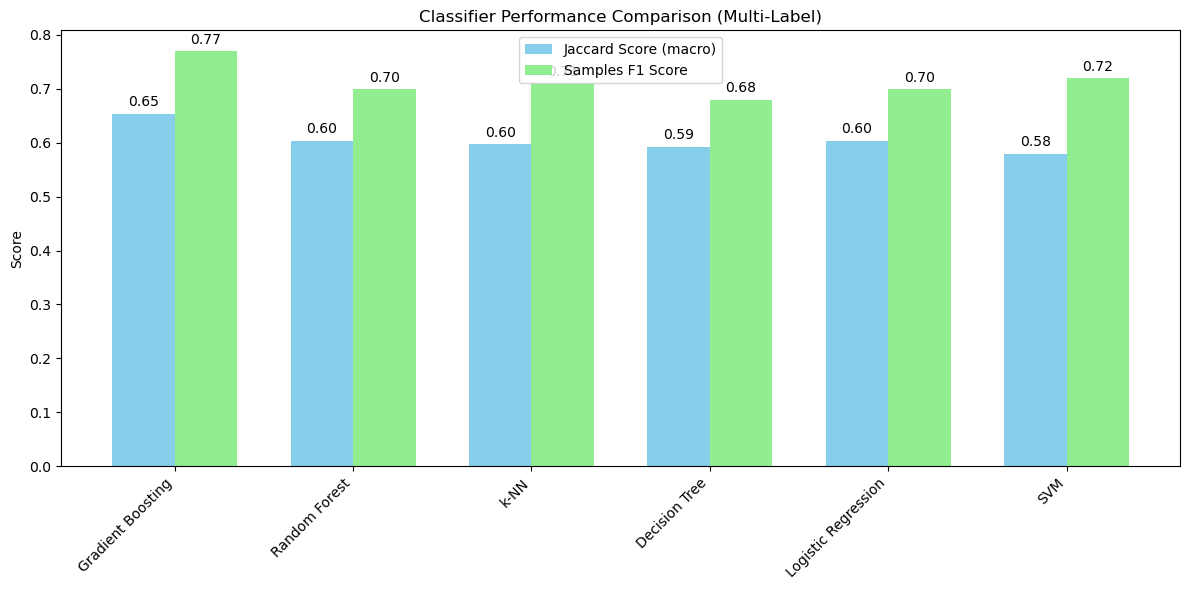

In [17]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Gradient Boosting', 'Random Forest', 'k-NN', 'Decision Tree', 'Logistic Regression', 'SVM']
jaccard = [0.654, 0.604, 0.597, 0.593, 0.604, 0.580]
f1 = [0.77, 0.70, 0.71, 0.68, 0.70, 0.72]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width/2, jaccard, width, label='Jaccard Score (macro)', color='skyblue')
bar2 = ax.bar(x + width/2, f1, width, label='Samples F1 Score', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Classifier Performance Comparison (Multi-Label)')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotate bars
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [18]:
import joblib

joblib.dump(gb_model, 'gradient_boost_model.joblib')



['gradient_boost_model.joblib']

In [19]:
# Step 4: Load the model from the saved file
loaded_model = joblib.load('gradient_boost_model.joblib')

# Predict with the loaded model (using the same test set as an example)
y_pred_loaded = loaded_model.predict(X_test)

# Print classification report to see if the loaded model performs the same
print(classification_report(y_test, y_pred_loaded))

              precision    recall  f1-score   support

           0       0.71      0.86      0.78       369
           1       0.79      0.93      0.85       472
           2       0.77      0.70      0.73       316

   micro avg       0.76      0.84      0.80      1157
   macro avg       0.76      0.83      0.79      1157
weighted avg       0.76      0.84      0.80      1157
 samples avg       0.75      0.84      0.77      1157



c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91749\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
import pandas as pd

# Example new input for a first-time visitor
new_data = pd.DataFrame([{

    'Age groups':4, 
    'Gender:':1, 
    'State/Country':1, 
    'Type of visitors':2, 
    'Are you camping at the Basilica?':1, 
    'Weekend':1, 
    'Is Feast Day':1
}])

# Predict event(s) the visitor is likely to attend
predicted_event = loaded_model.predict(new_data)

# If it's multioutput, this will return a 2D array (e.g., [[1, 0, 1]] for 3 events)
print("Predicted Event(s):", predicted_event)




Predicted Event(s): [[0 1 1]]


In [22]:
# Example: event label order used during training
event_labels = ['Fair/Cultural Event/Sightseeing', 'Veneration of Relics', 'Mass']

# Get predicted events (True = 1)
predicted_events_list = [event for event, val in zip(event_labels, predicted_event[0]) if val == 1]
print("Predicted Events:", predicted_events_list)

Predicted Events: ['Veneration of Relics', 'Mass']


In [23]:
def predict_from_raw_input(raw_input, model, le_gender, le_state, le_stay, le_age, le_visitcount, event_labels):
    # Encode input values
    encoded_input = {
        'Age groups': le_age.transform([raw_input['Age groups']])[0],
        'Gender:': le_gender.transform([raw_input['Gender:']])[0],
        'State/Country': le_state.transform([raw_input['State/Country']])[0],
        'Type of visitors': le_visitcount.transform([raw_input['Type of visitors']])[0],
        'Are you camping at the Basilica?': le_stay.transform([raw_input['Are you camping at the Basilica?']])[0],
        'Weekend': 1 if raw_input['Weekend'] == 'Yes' else 0,
        'Is Feast Day': 1 if raw_input['Is Feast Day'] == 'Yes' else 0
    }

    # Convert to DataFrame
    input_df = pd.DataFrame([encoded_input])

    # Make prediction
    y_pred = model.predict(input_df)

    # Decode predicted event labels
    predicted_events = [event_labels[i] for i, val in enumerate(y_pred[0]) if val == 1]

    # Display input info and predictions
    print("----- Visitor Info -----")
    for key, val in raw_input.items():
        print(f"{key}: {val}")
    
    print("\n Predicted Events:")
    if predicted_events:
        for event in predicted_events:
            print("-", event)
    else:
        print("No event predicted.")

    return predicted_events


In [53]:
'''raw_input = {
    'Age groups':'Mature Adults' ,
    'Gender:': 'Female',
    'State/Country': 'Goa',
    'Type of visitors': 'First time visitors',
    'Are you camping at the Basilica?': 'Yes',
    'Weekend': 'Yes',
    'Is Feast Day': 'Yes'
}

predict_from_raw_input(raw_input, loaded_model, le_gender, le_state, le_stay, le_age, le_visitcount, event_labels)
'''

"raw_input = {\n    'Age groups':'Mature Adults' ,\n    'Gender:': 'Female',\n    'State/Country': 'Goa',\n    'Type of visitors': 'First time visitors',\n    'Are you camping at the Basilica?': 'Yes',\n    'Weekend': 'Yes',\n    'Is Feast Day': 'Yes'\n}\n\npredict_from_raw_input(raw_input, loaded_model, le_gender, le_state, le_stay, le_age, le_visitcount, event_labels)\n"

In [24]:
# Decode the label-encoded categories to show original text values
valid_choices = {
    'Age groups': le_age.inverse_transform(sorted(df['Age groups'].unique())),
    'Gender:': le_gender.inverse_transform(sorted(df['Gender:'].unique())),
    'State/Country': le_state.inverse_transform(sorted(df['State/Country'].unique())),
    'Type of visitors': le_visitcount.inverse_transform(sorted(df['Type of visitors'].unique())),
    'Are you camping at the Basilica?': le_stay.inverse_transform(sorted(df['Are you camping at the Basilica?'].unique()))
}


In [25]:
def interactive_predict_event(model, le_gender, le_state, le_stay, le_age, le_visitcount, event_labels, valid_choices):
    print("\n Welcome to the Visitor Event Predictor!")
    print("Please enter values from the valid options shown below.\n")

    raw_input = {}

    for feature, options in valid_choices.items():
        print(f"{feature} options: {list(options)}")
        while True:
            user_input = input(f"Enter value for '{feature}': ")
            if user_input in options:
                raw_input[feature] = user_input
                break
            else:
                print("❌ Invalid input. Please enter exactly one of the shown options.")

    # Additional binary inputs
    raw_input['Weekend'] = input("Is it a Weekend? (Yes/No): ").strip().capitalize()
    raw_input['Is Feast Day'] = input("Is it Feast Day? (Yes/No): ").strip().capitalize()

    # Encode input
    try:
        encoded_input = {
            'Age groups': le_age.transform([raw_input['Age groups']])[0],
            'Gender:': le_gender.transform([raw_input['Gender:']])[0],
            'State/Country': le_state.transform([raw_input['State/Country']])[0],
            'Type of visitors': le_visitcount.transform([raw_input['Type of visitors']])[0],
            'Are you camping at the Basilica?': le_stay.transform([raw_input['Are you camping at the Basilica?']])[0],
            'Weekend': 1 if raw_input['Weekend'] == 'Yes' else 0,
            'Is Feast Day': 1 if raw_input['Is Feast Day'] == 'Yes' else 0
        }

        input_df = pd.DataFrame([encoded_input])
        y_pred = model.predict(input_df)
        predicted_events = [event_labels[i] for i, val in enumerate(y_pred[0]) if val == 1]

        print("\n✅ Prediction complete!\n")
        print("🎯 Predicted Events :")
        if predicted_events:
            for event in predicted_events:
                print("•", event)
        else:
            print("No specific event predicted.")
            
    except Exception as e:
        print("❌ Error during prediction:", str(e))


In [26]:
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(le_gender, 'encoders/le_gender.pkl')
joblib.dump(le_state, 'encoders/le_state.pkl')
# Save the rest of your label encoders similarly


NameError: name 'model' is not defined

In [56]:
interactive_predict_event(loaded_model, le_gender, le_state, le_stay, le_age, le_visitcount, event_labels, valid_choices)



 Welcome to the First-Time Visitor Event Predictor!
Please enter values from the valid options shown below.

Age groups options: ['early professionals', 'mature adults', 'senior citizen', 'young adults', 'young dependents', 'youth']
Gender: options: ['Male', 'female']
State/Country options: ['andhra pradesh', 'arunachal pradesh', 'assam', 'australia', 'belarus', 'bihar', 'chhattisgarh', 'delhi', 'fiji', 'france', 'germany', 'goa', 'gujarat', 'haryana', 'himachal pradesh', 'ireland', 'jammu & kashmir', 'jharkhand', 'karnataka', 'kerala', 'khazakistan', 'madhya pradesh', 'maharashtra', 'manipur', 'meghalaya', 'nagaland', 'nepal', 'netherlands', 'odisha', 'philippines', 'poland', 'portugal', 'punjab', 'rajasthan', 'russia', 'singapore', 'spain', 'switzerland', 'tamil nadu', 'tanzania', 'telangana', 'uk', 'usa', 'uttar pradesh', 'uttarakhand', 'washington dc', 'west bengal', 'zimbabwe']
Type of visitors options: ['first time visitors', 'frequent visitors', 'long-time devotees', 'ocassiona

In [57]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Convert Event column to binary multi-label
def prepare_event_columns(df, event_col="Event Attending"):
    df[event_col] = df[event_col].fillna("").apply(lambda x: [e.strip() for e in x.split(',')])
    mlb = MultiLabelBinarizer()
    event_df = pd.DataFrame(mlb.fit_transform(df[event_col]), columns=mlb.classes_, index=df.index)
    df = pd.concat([df.drop(columns=[event_col]), event_df], axis=1)
    return df, mlb.classes_

# 2. Cramér’s V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# 3. Analyze associations
def analyze_event_associations(df, event_cols, predictors):
    results = []
    for event in event_cols:
        for predictor in predictors:
            try:
                contingency = pd.crosstab(df[predictor], df[event])
                chi2, p, _, _ = chi2_contingency(contingency)
                v = cramers_v(df[predictor], df[event])
                results.append({
                    'Event': event,
                    'Predictor': predictor,
                    'Chi2 p-value': round(p, 4),
                    'Cramér\'s V': round(v, 4)
                })
            except Exception as e:
                print(f"Error with {predictor} and {event}: {e}")
    return pd.DataFrame(results).sort_values(by="Cramér's V", ascending=False)


In [28]:
import joblib
model = joblib.load('gradient_boost_model.joblib')


In [29]:
import pickle

# Save the model
with open('gradient_boost_model.pkl', 'wb') as f:
    pickle.dump(loaded_model, f)


In [30]:
# Load the model
with open('gradient_boost_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [31]:
with open('encoders.pkl', 'wb') as f:
    pickle.dump({
        'le_gender': le_gender,
        'le_state': le_state,
        'le_stay': le_stay,
        'le_age': le_age,
        'le_visitcount': le_visitcount
    }, f)


In [32]:
with open('encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

le_gender = encoders['le_gender']
le_state = encoders['le_state']
le_stay = encoders['le_stay']
le_age = encoders['le_age']
le_visitcount = encoders['le_visitcount']


In [58]:
# 4. Analyze associations
association_results = analyze_event_associations(df, y, X)

# 5. View results
print(association_results)

                              Event                         Predictor  \
17                             Mass                  Type of visitors   
2   Fair/Cultural Event/Sightseeing                     State/Country   
9              Veneration of Relics                     State/Country   
16                             Mass                     State/Country   
18                             Mass  Are you camping at the Basilica?   
6   Fair/Cultural Event/Sightseeing                      Is Feast Day   
3   Fair/Cultural Event/Sightseeing                  Type of visitors   
0   Fair/Cultural Event/Sightseeing                        Age groups   
5   Fair/Cultural Event/Sightseeing                           Weekend   
14                             Mass                        Age groups   
11             Veneration of Relics  Are you camping at the Basilica?   
4   Fair/Cultural Event/Sightseeing  Are you camping at the Basilica?   
20                             Mass                

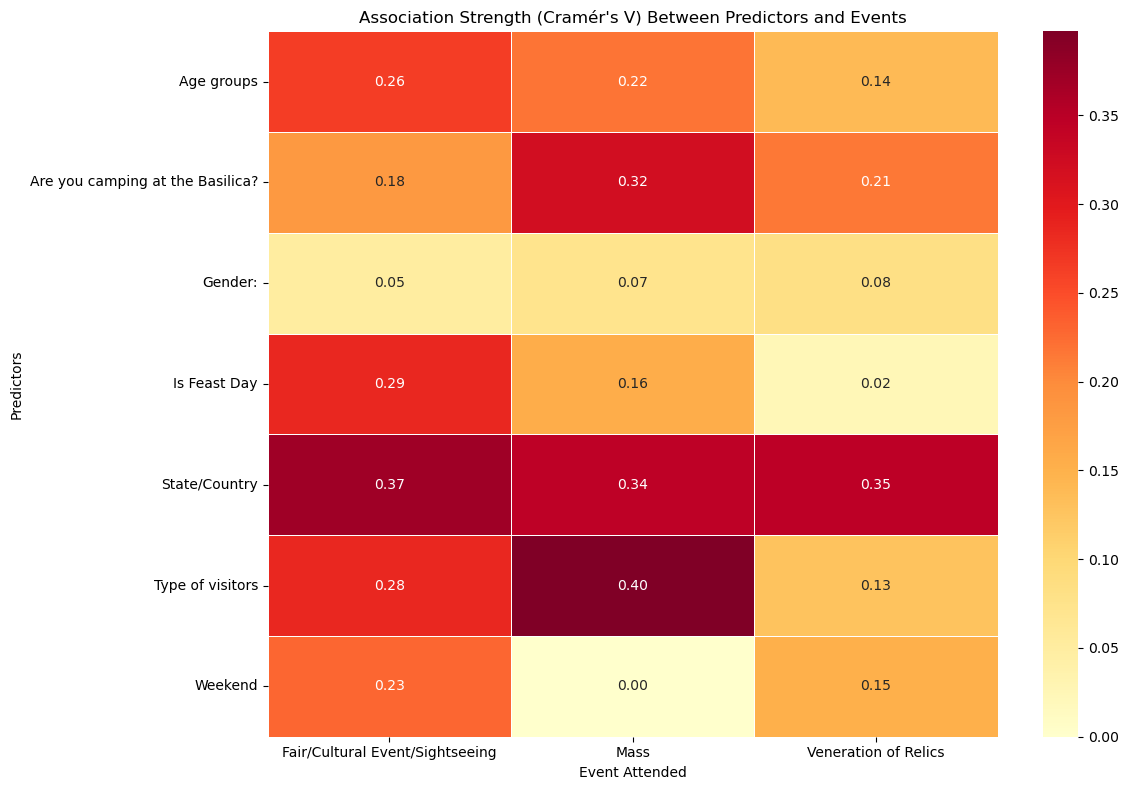

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the results to a matrix format suitable for a heatmap
heatmap_data = association_results.pivot(index='Predictor', columns='Event', values="Cramér's V")

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', linewidths=0.5, fmt=".2f")
plt.title("Association Strength (Cramér's V) Between Predictors and Events")
plt.ylabel("Predictors")
plt.xlabel("Event Attended")
plt.tight_layout()
plt.show()
import seaborn as sns
import matplotlib.pyplot as plt
